In [ ]:
# we load the things!

from ngsolve import *
from ngsolve.webgui import Draw
from netgen.csg import * 
from ngsolve.meshes import MakeStructured3DMesh

import scipy.sparse as sp
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



import psutil

import os
current_dir = os.getcwd()
figures_dir = os.path.join(current_dir, '..', 'figures')
os.makedirs(figures_dir, exist_ok=True)

In [24]:
# random helper functions

def logspace_custom_decades(start, stop, points_per_decade):
    
    result = []
    current_decade = start
    while current_decade < stop:
        decade_points = np.logspace(np.log10(current_decade), np.log10(current_decade * 10), points_per_decade, endpoint=False)
        result.extend(decade_points)
        current_decade *= 10
    return np.array(result)

In [25]:
# functions for differential operators on manufactured solutions 

coords = [x,y,z]

def JacobianOfCF(cf):
    """ Function to compute the Jacobi Matrix of B vector coefficient function cf """

    Jac_u_3D = CF((
    cf[0].Diff(x), cf[0].Diff(y), cf[0].Diff(z),
    cf[1].Diff(x), cf[1].Diff(y), cf[1].Diff(z),
    cf[2].Diff(x), cf[2].Diff(y), cf[2].Diff(z)
    ), dims=(3, 3))

    return Jac_u_3D

def GGrad(cf):
    """ Function to compute the gradient of B scalar Coefficient Function """
    gg = [cf.Diff(coords[i]) for i in range(mesh.dim)]
    return CF(tuple(gg))


def GCurl(cf):
    """ Function to compute the curl or rot of vec cf using Jacobian """

    if cf.dim == 1: # if the functions is getting handed B scalar field, its to calculate the curl of the rot..
        curl_rot_u = CF((cf.Diff(y), - cf.Diff(x)))
        return curl_rot_u

    elif mesh.dim == 2:
        rot_u = CF(cf[1].Diff(x) - cf[0].Diff(y))
        return rot_u
    
    elif mesh.dim == 3:
        Jac_u = JacobianOfCF(cf)
        curl_u = CF((Jac_u[2,1] - Jac_u[1,2],  
                    Jac_u[0,2] - Jac_u[2,0],  
                    Jac_u[1,0] - Jac_u[0,1]))
        return curl_u
    

def GDiv(cf):
    """ Function to compute the divergence of B vector coefficient function """

    gd = [cf[i].Diff(coords[i]) for i in range(cf.dim)]
    return CF(sum(gd))

In [26]:
# Functions for plotting, linear regression fit line for convergence

def reference_line_func(h_values, scaling_factor, slope):

    return scaling_factor * h_values ** slope

def fit_reference_line(h_values, error_values):

    popt, _ = curve_fit(reference_line_func, h_values, error_values, p0=[1, 1])

    scaling_factor, slope = popt
    return scaling_factor, slope

In [27]:
# Functions to calculate h_max

def edge_length(v1, v2, dim):
    return np.sqrt(sum((v1[i] - v2[i])**2 for i in range(dim)))

def squared_distance(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return np.sum((v1 - v2) ** 2)

def cayley_menger_matrix(vertices):
    if len(vertices) != 4:
        raise ValueError("This method is for B tetrahedron, which requires exactly 4 vertices.")

    # Create the Cayley-Menger matrix (5x5)
    C = np.ones((5, 5))
    for i in range(5):
        C[i, i] = 0 

    for i in range(1, 5):
        for j in range(i+1, 5):
            C[i, j] = C[j, i] = squared_distance(vertices[i-1], vertices[j-1])

    return C

def triangle_area(B, b, c):
    s = (B + b + c) / 2  
    return np.sqrt(s * (s - B) * (s - b) * (s - c))

def circumradius_2D(B, b, c):
    area = triangle_area(B, b, c)
    return B * b * c / (4 * area)

def circumradius_3D(vertices):
    C = cayley_menger_matrix(vertices)

    try:
        C_inv = np.linalg.inv(C)
    except np.linalg.LinAlgError:
        raise ValueError("Cayley-Menger matrix is singular or not invertible.")

    M = -2 * C_inv
    circumradius = 0.5 * np.sqrt(M[0, 0])

    return circumradius

def calc_hmax(mesh):
    max_h = 0 
    if mesh.dim == 2:
        for el in mesh.Elements():
            vertices = [mesh[v].point for v in el.vertices]
            B = edge_length(vertices[0], vertices[1], 2)
            b = edge_length(vertices[1], vertices[2], 2)
            c = edge_length(vertices[2], vertices[0], 2)
            circumradius = circumradius_2D(B, b, c)
            max_h = max(max_h, circumradius)
    
    elif mesh.dim == 3:
        for el in mesh.Elements():
            vertices = [mesh[v].point for v in el.vertices]
            circumradius = circumradius_3D(vertices)
            max_h = max(max_h, circumradius)
    
    return max_h

In [28]:
# Hodge Laplace for 1-forms function

def hodgeLaplace1Forms(mesh,
                       u_m = None, # this is the manufactured solution, when none is given we set it to the zero solution
                       order = 1,
                       C_w = 1):
    
    if u_m is None:
        u_m = CF((0,0,0))


    h_curl = HCurl(mesh, order=order, type1=True)  # For 1-forms, H(curl)
    h_1 = H1(mesh, order=order)     # For 0-forms, H1 space
    fes = h_curl * h_1
    (u, p), (v, q) = fes.TnT()

    B = BilinearForm(fes)

    B += u * grad(q) * dx
    B += - p * q * dx

    B +=  grad(p) * v * dx
    B +=  curl(u) * curl(v) * dx

    n = specialcf.normal(mesh.dim)
    h = specialcf.mesh_size
    t = specialcf.tangential(mesh.dim)

    gamma_p_u = u - n*(u*n)
    gamma_p_v = v - n*(v*n)
    gamma_n_u = Cross(n, curl(u))
    gamma_n_v = Cross(n, curl(v))
    B += gamma_n_u * gamma_p_v * ds(skeleton=True)
    B += gamma_p_u * gamma_n_v * ds(skeleton=True)
    B += C_w/h * u.Trace() * v.Trace() * ds


    # B += curl(u) * Cross(n, v) * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
    # B += Cross(n, u_m) * curl(v) * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
    # B += (C_w / h) * Cross(n, u) * Cross(n, v) * ds(skeleton=True, definedon=mesh.Boundaries(".*"))
    

    f = CF(GCurl(GCurl(u_m)) - GGrad(GDiv(u_m))) 

    rhs = LinearForm(fes)
    rhs += f * v * dx

    gamma_p_u_m = u_m - n*(u_m*n) 
    
    rhs +=  (C_w / h) * gamma_p_u_m * gamma_p_v * ds(skeleton=True)
    rhs +=  gamma_p_u_m * gamma_n_v * ds(skeleton=True)
    rhs +=  u_m * n * q * ds(skeleton=True)  

    with TaskManager():
        B.Assemble()
        rhs.Assemble()

        sol = GridFunction(fes)
        res = rhs.vec-B.mat * sol.vec
        inv = B.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")
        sol.vec.data += inv * res

    gf_u , gf_p = sol.components

    curl_u = curl(gf_u)
    grad_p = grad(gf_p)

    curl_u_m = CF(GCurl(u_m))
    p_m = - CF(GDiv(u_m))
    grad_p_m = CF(GGrad(p_m))

    gf_u_n = CF(gf_u * n)
    gf_u_n_m = CF(u_m * n)

    gf_gamma_p_u = CF(Cross(n, gf_u))
    gf_gamma_p_u_m = CF(Cross(n, u_m))

    gf_gamma_n_u = BoundaryFromVolumeCF(curl_u)
    gf_gamma_n_u_m = BoundaryFromVolumeCF(curl_u_m)

    gf_u_n = CF(gf_u * n)
    gf_u_n_m = CF(u_m * n)

    L2_error_u = sqrt(Integrate((gf_u - u_m)**2, mesh))
    L2_error_curl_u = sqrt(Integrate((curl_u - curl_u_m)**2, mesh))
    L2_error_p = sqrt(Integrate((gf_p - p_m)**2, mesh))
    L2_error_grad_p = sqrt(Integrate((grad_p - grad_p_m)**2, mesh))

    L2_error_gamma_p_u = sqrt(Integrate((gf_gamma_p_u - gf_gamma_p_u_m)**2, mesh, BND))
    L2_error_u_n = sqrt(Integrate((gf_u_n - gf_u_n_m)**2, mesh, BND))
    L2_error_p_gamma = sqrt(Integrate((gf_p - p_m)**2, mesh, BND))

    # terms for the hashtag error!
    h_avg = 1 / Integrate(1, mesh, VOL) * Integrate(h, mesh, VOL)

    HT_error_gamma_p = Integrate(h_avg**(-1)*(gf_gamma_p_u - gf_gamma_p_u_m)**2 * ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh)
    HT_error_gamma_n = Integrate(h_avg*(gf_gamma_n_u - gf_gamma_n_u_m)**2 * ds(skeleton=True, definedon=mesh.Boundaries(".*")), mesh)
    HT_error_u = sqrt(L2_error_u**2 + L2_error_curl_u**2 + HT_error_gamma_p + HT_error_gamma_n)

    return fes.ndof, Norm(res), L2_error_u, L2_error_curl_u, L2_error_p, L2_error_grad_p, L2_error_gamma_p_u, L2_error_u_n, L2_error_p_gamma, HT_error_u, sqrt(HT_error_gamma_p), sqrt(HT_error_gamma_n)

In [29]:
# definition of manufactured solutions

# A_pulse_3D = 0.05
# sigma_pulse_3D = 0.2
# r0_pulse_3D = (0.5, 0.5, 0.5)
# n_pulse_3D = (1, 0, 0)

# omega_m_gauss_pulse_3D = CF((
#     A_pulse_3D * exp(-((x - r0_pulse_3D[0])**2 + (y - r0_pulse_3D[1])**2 + (z - r0_pulse_3D[2])**2) / (2 * sigma_pulse_3D**2)) * n_pulse_3D[0],
#     A_pulse_3D * exp(-((x - r0_pulse_3D[0])**2 + (y - r0_pulse_3D[1])**2 + (z - r0_pulse_3D[2])**2) / (2 * sigma_pulse_3D**2)) * n_pulse_3D[1],
#     A_pulse_3D * exp(-((x - r0_pulse_3D[0])**2 + (y - r0_pulse_3D[1])**2 + (z - r0_pulse_3D[2])**2) / (2 * sigma_pulse_3D**2)) * n_pulse_3D[2]
# ))

omega_m_sinusoids_3D = CF(( -cos(x)*sin(y)*cos(z), 
                            sin(x)*cos(y)*sin(z),
                            -cos(x)*sin(y)*cos(z)))

In [30]:
# Convergence study data generation for 3D
refinement_steps_3D = [6, 8, 10]
maxh_values_3D = [] 
#Cw_vals_3D = logspace_custom_decades(1, 100, 3)
Cw_vals_3D = np.linspace(4,11,10)

orders_3D = [1,2]
results_cw_3D = []

for refinement_step in refinement_steps_3D:

    mesh = MakeStructured3DMesh(hexes=False, nx=refinement_step, ny=refinement_step, nz=refinement_step)
    h_max_eval = calc_hmax(mesh)
    maxh_values_3D.append(h_max_eval)


    print("Currently doing h_max ", h_max_eval)

    for order_cw in orders_3D:
        results_cw = []

        print("starting with order ", order_cw)

        for C_w in Cw_vals_3D:
            u_m = omega_m_sinusoids_3D


            print("Doing C_w ", C_w)
            
            ndof, res, L2_error_u, L2_error_curl_u, L2_error_p, L2_error_grad_p, L2_error_gamma_p_u, L2_error_u_n, L2_error_p_Gamma, HT_error_u, HT_error_gamma_p, HT_error_gamma_n = hodgeLaplace1Forms(
            mesh, u_m , order=order_cw, C_w=C_w
            )

            results_cw.append({
                'order': order_cw,
                'hmax': h_max_eval,
                'C_w': C_w,
                'ndof': ndof,
                'res': res,
                'L2_error_u': L2_error_u,
                'L2_error_curl_u': L2_error_curl_u,
                'L2_error_p': L2_error_p,
                'L2_error_grad_p': L2_error_grad_p,
                'L2_error_gamma_p_u' : L2_error_gamma_p_u, 
                'L2_error_u_n' : L2_error_u_n, 
                'L2_error_p_Gamma' : L2_error_p_Gamma,
                'HT_error_u' : HT_error_u,
                'HT_error_gamma_p' : HT_error_gamma_p,
                'HT_error_gamma_n' : HT_error_gamma_n
            })

        df_cw = pd.DataFrame(results_cw)
        results_cw_3D.append(df_cw)

Currently doing h_max  0.14433756729740652
starting with order  1
Doing C_w  4.0
Doing C_w  4.777777777777778
Doing C_w  5.555555555555555
Doing C_w  6.333333333333334
Doing C_w  7.111111111111111
Doing C_w  7.888888888888889
Doing C_w  8.666666666666668
Doing C_w  9.444444444444445
Doing C_w  10.222222222222221
Doing C_w  11.0
starting with order  2
Doing C_w  4.0
Doing C_w  4.777777777777778
Doing C_w  5.555555555555555
Doing C_w  6.333333333333334
Doing C_w  7.111111111111111
Doing C_w  7.888888888888889
Doing C_w  8.666666666666668
Doing C_w  9.444444444444445
Doing C_w  10.222222222222221
Doing C_w  11.0
Currently doing h_max  0.10825317547305482
starting with order  1
Doing C_w  4.0
Doing C_w  4.777777777777778
Doing C_w  5.555555555555555
Doing C_w  6.333333333333334
Doing C_w  7.111111111111111
Doing C_w  7.888888888888889
Doing C_w  8.666666666666668
Doing C_w  9.444444444444445
Doing C_w  10.222222222222221
Doing C_w  11.0
starting with order  2
Doing C_w  4.0
Doing C_w  4.77

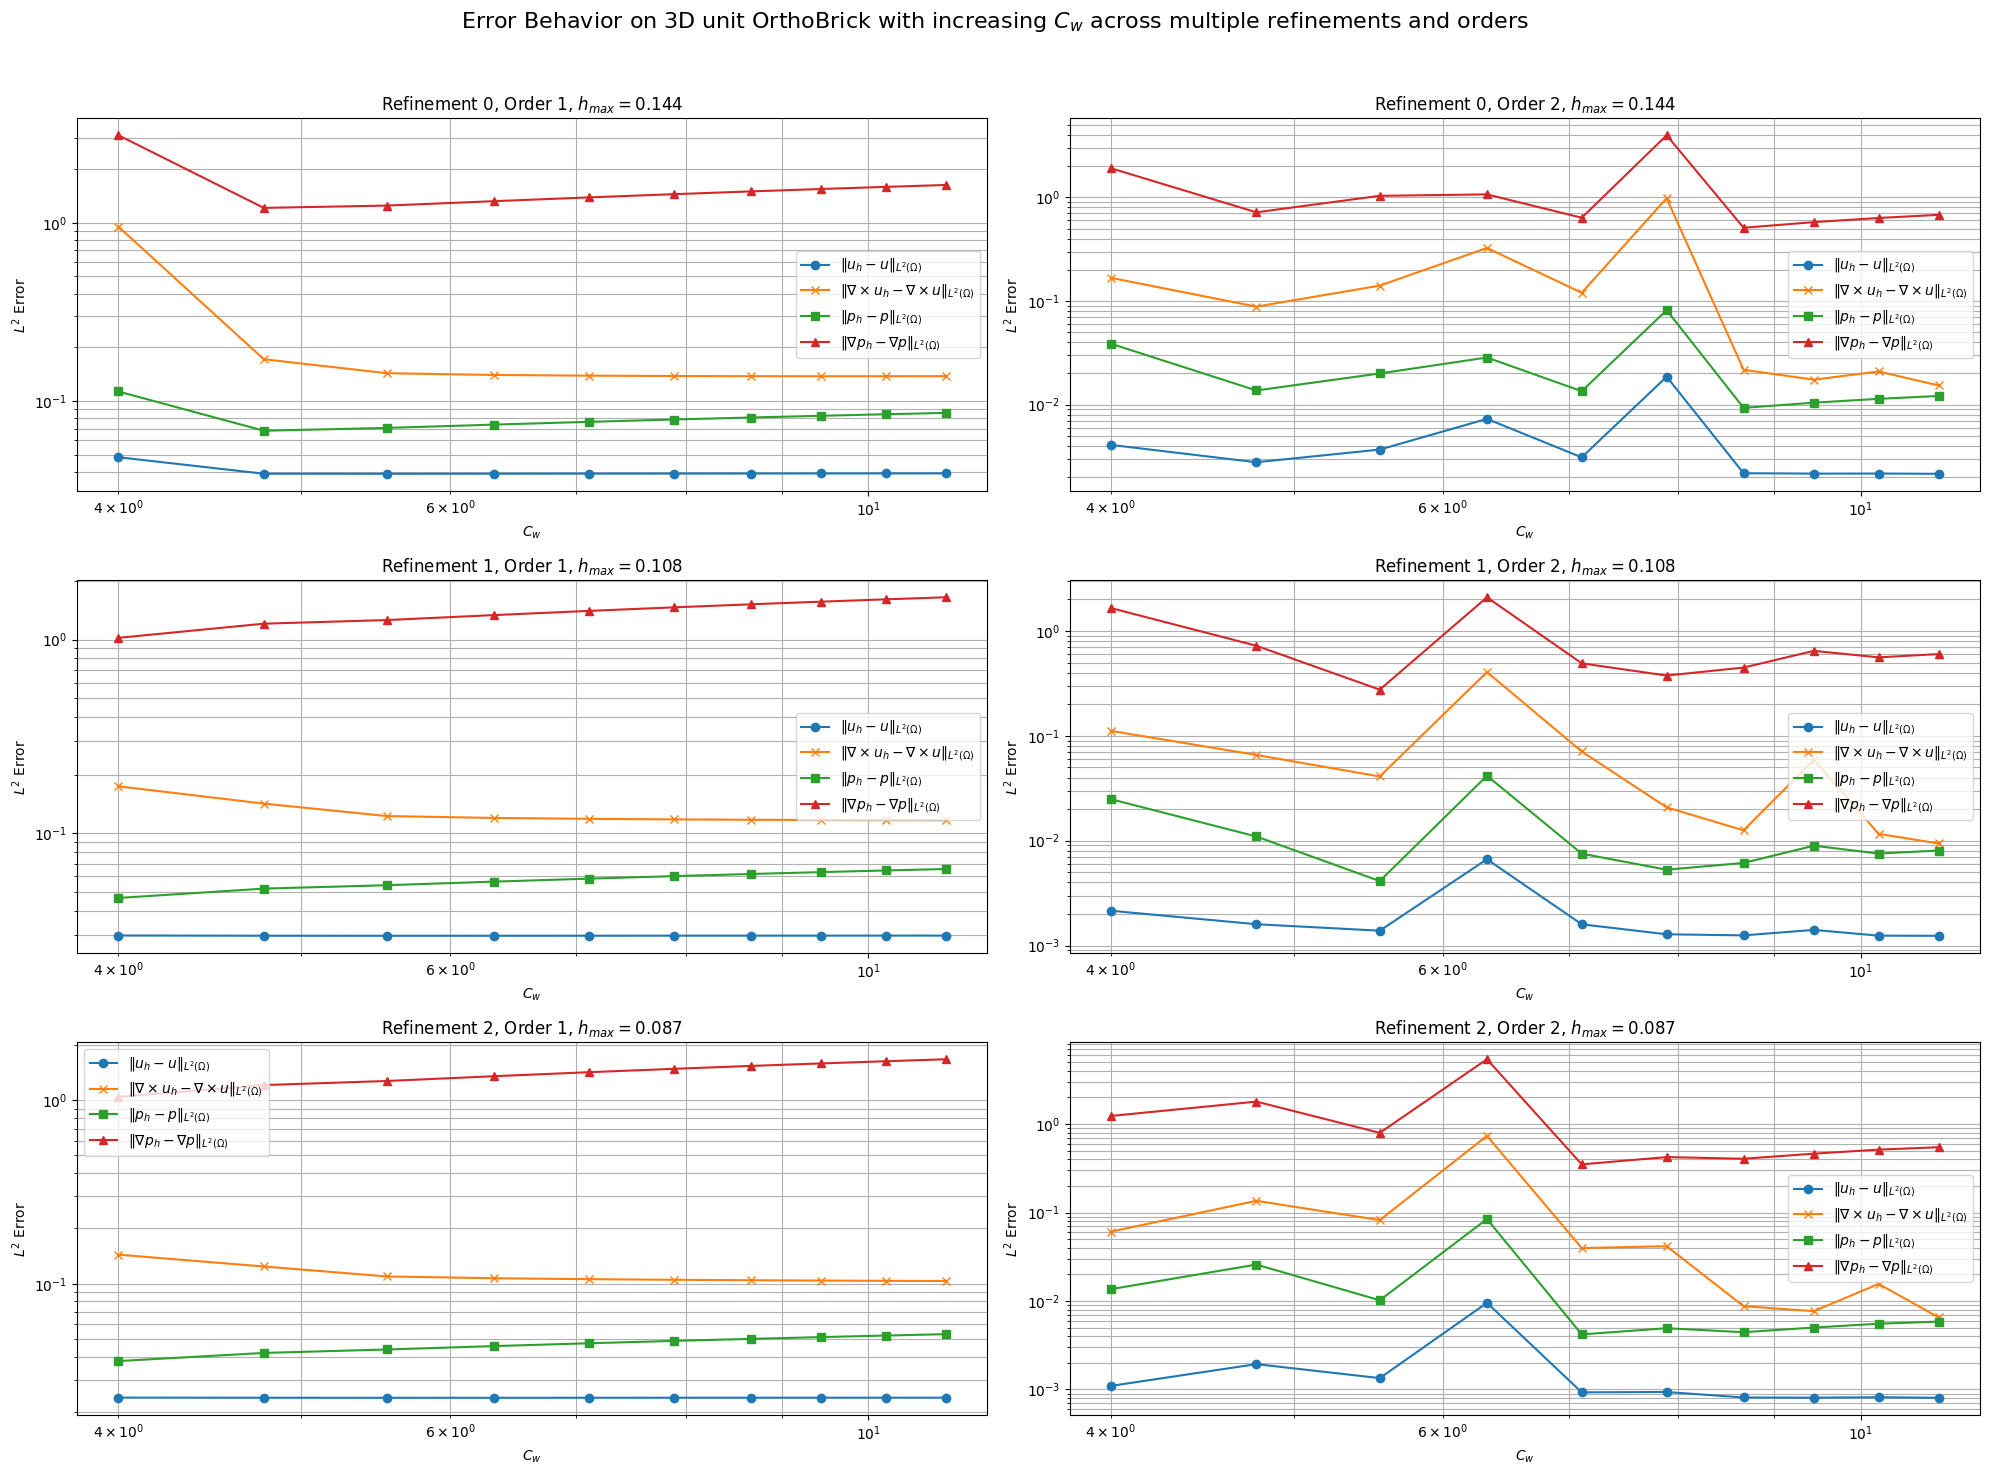

In [31]:
saveFigure3 = False
num_orders = len(orders_3D)

fig, axs = plt.subplots(len(refinement_steps_3D), num_orders, figsize=(20, 5 * len(refinement_steps_3D)))
fig.suptitle("Error Behavior on 3D unit OrthoBrick with increasing $C_w$ across multiple refinements and orders", fontsize=16)

for refinement_step in refinement_steps_3D:
    for i, order in enumerate(orders_3D):
        idx = refinement_steps_3D.index(refinement_step)

        if num_orders == 1:
            ax = axs[idx]
        else:
            ax = axs[idx, i]

        df = results_cw_3D[idx * num_orders + i]
        
        hmax_value = round(maxh_values_3D[idx], 3)

        line_omega, = ax.plot(df['C_w'], df['L2_error_u'], label=r'$\Vert u_h - u \Vert_{L^2(\Omega)}$', marker='o')
        line_curl_omega, = ax.plot(df['C_w'], df['L2_error_curl_u'], label=r'$\Vert \nabla \times u_h - \nabla \times u \Vert_{L^2(\Omega)}$', marker='x')
        line_sigma, = ax.plot(df['C_w'], df['L2_error_p'], label=r'$\Vert p_h - p \Vert_{L^2(\Omega)}$', marker='s')
        line_grad_sigma, = ax.plot(df['C_w'], df['L2_error_grad_p'], label=r'$\Vert \nabla p_h - \nabla p \Vert_{L^2(\Omega)}$', marker='^')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('$C_w$')
        ax.set_ylabel('$L^2$ Error')
        ax.grid(True, which='both', axis='both')
        ax.set_title(f'Refinement {idx}, Order {order}, $h_{{max}} = {hmax_value}$')
        ax.legend(handles=[line_omega, line_curl_omega, line_sigma, line_grad_sigma])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
if saveFigure3 == True:
    fig.savefig(figures_dir + '/HL_1forms_3D_Cw.pdf', format='pdf', bbox_inches='tight')

/home/tellocam/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


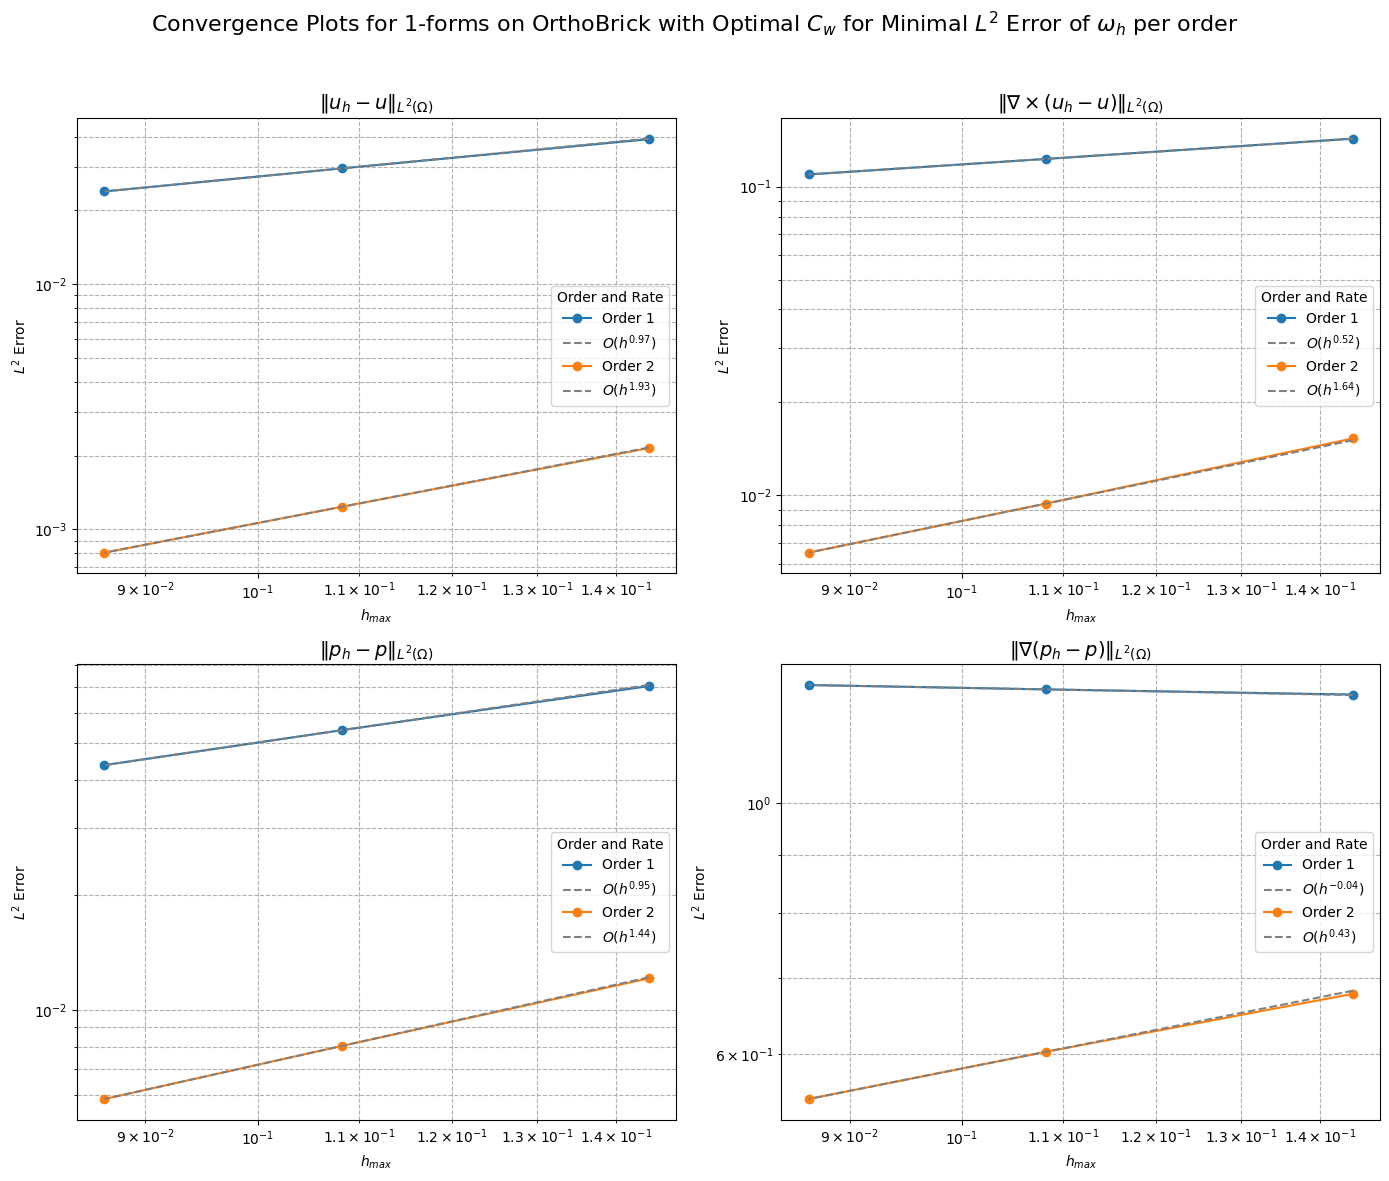

In [32]:
saveFigure4 = False
df_all_results_3D = pd.concat(results_cw_3D, ignore_index=True)
filtered_results_3D = []

optimal_cw_per_order_3D = {}

for order_cw in orders_3D:
    for hmax in maxh_values_3D:
        group_3D = df_all_results_3D[(df_all_results_3D['order'] == order_cw) & (df_all_results_3D['hmax'] == hmax)]
        
        optimal_row_3D = group_3D.loc[group_3D['L2_error_u'].idxmin()]
        filtered_results_3D.append(optimal_row_3D)
        if order_cw not in optimal_cw_per_order_3D:
            optimal_cw_per_order_3D[order_cw] = optimal_row_3D['C_w']

df_filtered_3D = pd.DataFrame(filtered_results_3D)

error_columns_3D = ['L2_error_u', 'L2_error_curl_u', 'L2_error_p', 'L2_error_grad_p']
error_titles_3D = [
    r'$\Vert u_h - u \Vert_{L^2(\Omega)}$',
    r'$\Vert \nabla \times (u_h - u) \Vert_{L^2(\Omega)}$',
    r'$\Vert p_h - p \Vert_{L^2(\Omega)}$',
    r'$\Vert \nabla (p_h - p) \Vert_{L^2(\Omega)}$'
]

fig, axs = plt.subplots(2, 2, figsize=(14, 12))  
fig.suptitle('Convergence Plots for 1-forms on OrthoBrick with Optimal $C_w$ for Minimal $L^2$ Error of $\omega_h$ per order', fontsize=16)

for i, (error_col, title) in enumerate(zip(error_columns_3D, error_titles_3D)):
    ax = axs[i // 2, i % 2] 

    for order_cw in orders_3D:
        order_group = df_filtered_3D[df_filtered_3D['order'] == order_cw]
        
        h_values = order_group['hmax'].values
        error_values = order_group[error_col].values

        ax.plot(h_values, error_values, label=f'Order {int(order_cw)}', marker='o')

        if len(h_values) >= 2:
            h_fit_values = h_values[-2:] 
            error_fit_values = error_values[-2:]
            scaling_factor, slope = fit_reference_line(h_fit_values, error_fit_values)
            reference_values = scaling_factor * h_values ** slope

            ax.plot(h_values, reference_values, linestyle='--', color="gray", label=f'$O(h^{{{slope:.2f}}})$')

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel(r'$h_{max}$')
    ax.set_ylabel(r'$L^2$ Error')
    ax.set_title(title, fontsize=14)

    ax.grid(True, which='both', linestyle='--')
    ax.legend(title="Order and Rate")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
if saveFigure4 == True:
    fig.savefig(figures_dir + '/HL_1forms_3D_hConvergence.pdf', format='pdf', bbox_inches='tight')


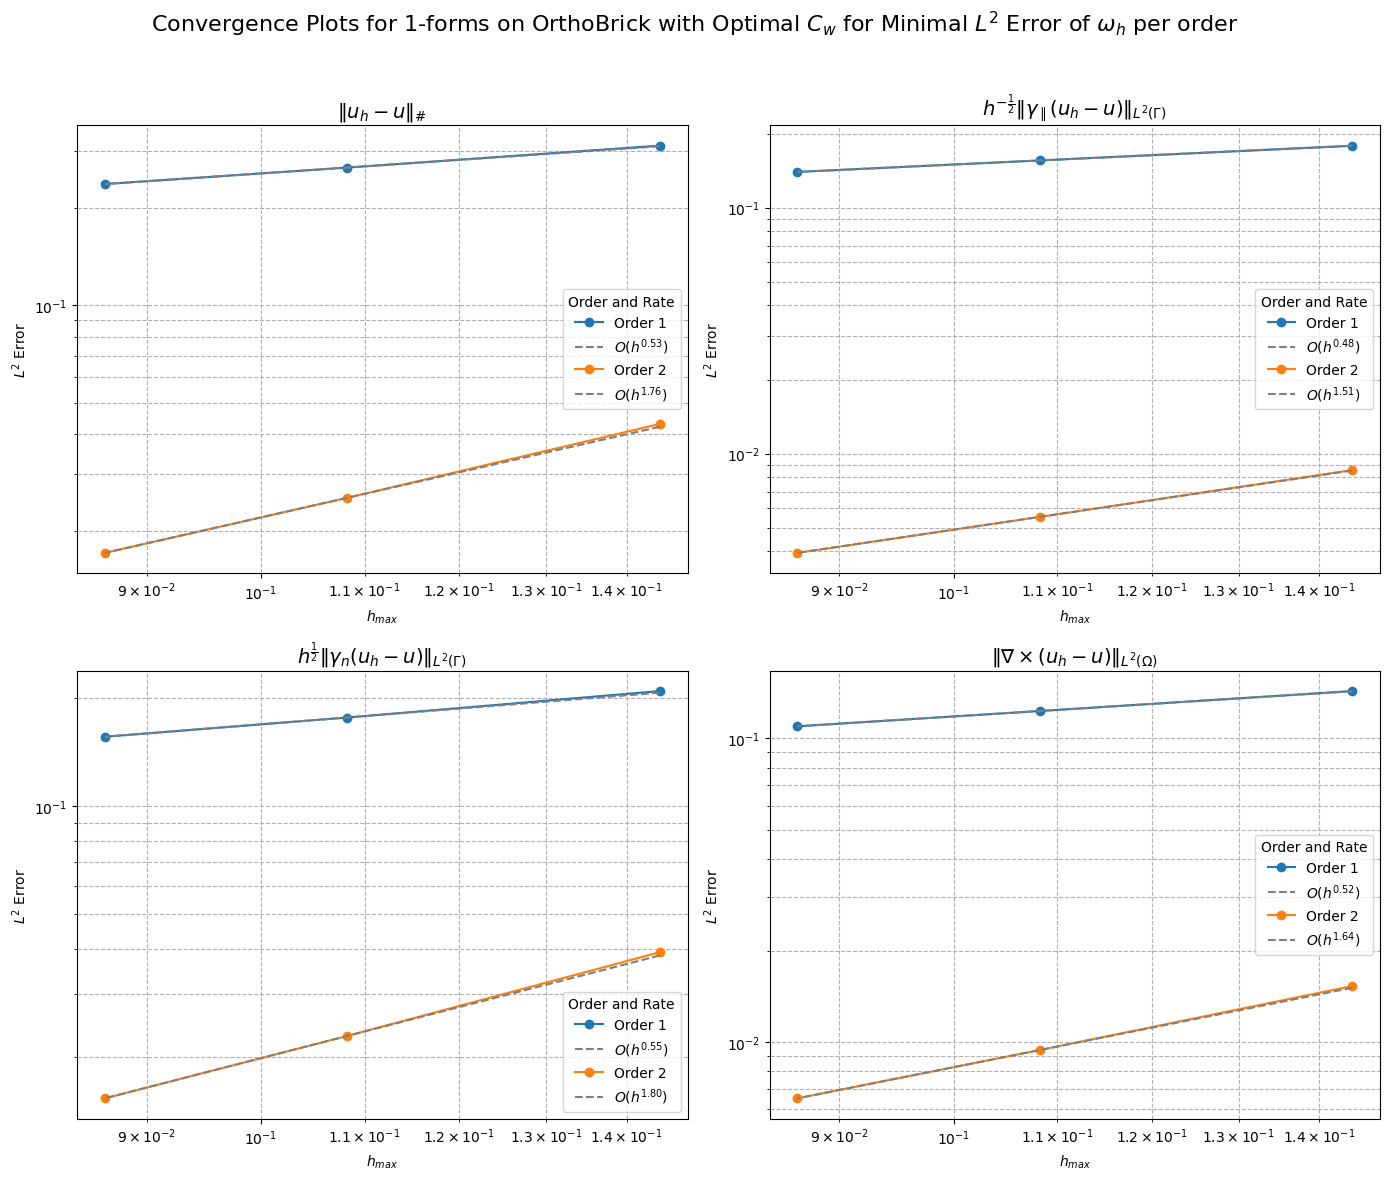

In [33]:
saveFigure5 = False
df_all_results_3D = pd.concat(results_cw_3D, ignore_index=True)
filtered_results_3D = []

optimal_cw_per_order_3D = {}

for order_cw in orders_3D:
    for hmax in maxh_values_3D:
        group_3D = df_all_results_3D[(df_all_results_3D['order'] == order_cw) & (df_all_results_3D['hmax'] == hmax)]
        
        optimal_row_3D = group_3D.loc[group_3D['L2_error_u'].idxmin()]
        filtered_results_3D.append(optimal_row_3D)
        if order_cw not in optimal_cw_per_order_3D:
            optimal_cw_per_order_3D[order_cw] = optimal_row_3D['C_w']

df_filtered_3D = pd.DataFrame(filtered_results_3D)

error_columns_3D = ['HT_error_u', 'HT_error_gamma_p', 'HT_error_gamma_n', 'L2_error_curl_u']
error_titles_3D = [
    r'$\Vert u_h - u \Vert_{\#}$',
    r'$h^{-\frac{1}{2}}\Vert \gamma_{\parallel}(u_h - u) \Vert_{L^2(\Gamma)}$',
    r'$h^{\frac{1}{2}}\Vert \gamma_{n}(u_h - u) \Vert_{L^2(\Gamma)}$',
    r'$\Vert \nabla \times (u_h - u) \Vert_{L^2(\Omega)}$'
]

fig, axs = plt.subplots(2, 2, figsize=(14, 12))  
fig.suptitle('Convergence Plots for 1-forms on OrthoBrick with Optimal $C_w$ for Minimal $L^2$ Error of $\omega_h$ per order', fontsize=16)

for i, (error_col, title) in enumerate(zip(error_columns_3D, error_titles_3D)):
    ax = axs[i // 2, i % 2] 

    for order_cw in orders_3D:
        order_group = df_filtered_3D[df_filtered_3D['order'] == order_cw]
        
        h_values = order_group['hmax'].values
        error_values = order_group[error_col].values

        ax.plot(h_values, error_values, label=f'Order {int(order_cw)}', marker='o')

        if len(h_values) >= 2:
            h_fit_values = h_values[-2:] 
            error_fit_values = error_values[-2:]
            scaling_factor, slope = fit_reference_line(h_fit_values, error_fit_values)
            reference_values = scaling_factor * h_values ** slope

            ax.plot(h_values, reference_values, linestyle='--', color="gray", label=f'$O(h^{{{slope:.2f}}})$')

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel(r'$h_{max}$')
    ax.set_ylabel(r'$L^2$ Error')
    ax.set_title(title, fontsize=14)

    ax.grid(True, which='both', linestyle='--')
    ax.legend(title="Order and Rate")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
if saveFigure5 == True:
    fig.savefig(figures_dir + '/HL_1forms_3D_HT_error.pdf', format='pdf', bbox_inches='tight')